In [ ]:
# Import necessary modules.

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive

In [ ]:
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
images = np.load ('/content/drive/My Drive/AIML/images.npy')


In [ ]:
images.shape

(4750, 128, 128, 3)

In [ ]:
pd_labels = pd.read_csv('/content/drive/My Drive/AIML/Labels.csv')
pd_labels

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill
...,...
4745,Loose Silky-bent
4746,Loose Silky-bent
4747,Loose Silky-bent
4748,Loose Silky-bent


In [ ]:
#Check the number of unique labels
pd_labels.shape

(4750, 1)

In [ ]:
label_array = np.unique(pd_labels)
label_array

array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
       'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
       'Scentless Mayweed', 'Shepherds Purse',
       'Small-flowered Cranesbill', 'Sugar beet'], dtype=object)

Small-flowered Cranesbill


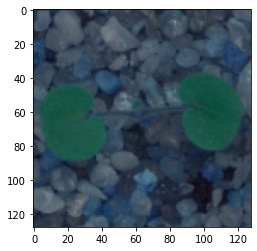

In [ ]:
#Visualize Images
#First image
#128 pixels in each direction
i = 0
image = images[i]
label = pd_labels['Label'].values[i]
print(label)
plt.imshow(image);

Loose Silky-bent


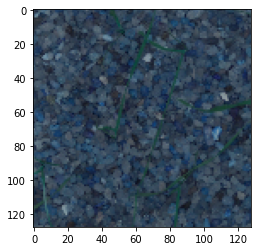

In [ ]:
#Last image
i = 4749
image = images[i]
label = pd_labels['Label'].values[i]
print(label)
plt.imshow(image);

In [ ]:
# Import label encoder 
from sklearn.preprocessing import LabelEncoder
lb_encod  =  LabelEncoder()
pd_labels.Label= lb_encod.fit_transform(pd_labels.Label.values)
pd_labels

,Label
0,10
1,10
2,10
3,10
4,10
...,...
4745,6
4746,6
4747,6
4748,6


In [ ]:
#Split into Training, Testing and Validation Data
from sklearn.model_selection import train_test_split
num_classes = len(np.unique(pd_labels))
len_data = len(images)

x_train, x_test, y_train, y_test = train_test_split(images, pd_labels.Label, test_size=0.15)

In [ ]:
x_train.shape

(4037, 128, 128, 3)

In [ ]:
x_test.shape

(713, 128, 128, 3)

In [ ]:
y_train.shape

(4037,)

In [ ]:
y_test.shape

(713,)

In [ ]:
#Pre-processing
#Normalization
x_train = x_train.astype('float32') # Conversion to float type from integer type.
x_test = x_test.astype('float32')
x_train /= 255.0 # Division by 255
x_test /= 255.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


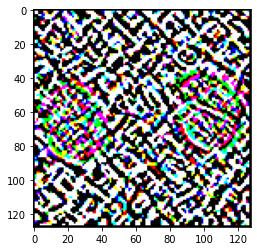

In [ ]:
#visualize image with sobel
sobel = cv2.Sobel(images[0], cv2.CV_64F, 1, 1, ksize=5)
plt.imshow(sobel)

In [ ]:
## One hot encode labels
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
x_train.shape[1:]

(128, 128, 3)

In [ ]:
# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
# initiate Adam optimizer
opt = keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
# Network structure is summarized which confirms our design was implemented correctly.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        1

In [ ]:
#Adding Early stopping callback to the fit function is going to stop the training,
#if the val_loss is not going to change even '0.001' for more than 10 continous epochs
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training

model_checkpoint =  ModelCheckpoint('cifar_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)

In [ ]:
# Set the batch size, number of epochs.
batch_size = 32
epochs = 30

In [ ]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split = 0.15,
          shuffle=True,
          verbose=1,
          callbacks=[early_stopping,model_checkpoint])

Epoch 1/30
108/108 [==============================] - ETA: 0s - loss: 2.3594 - accuracy: 0.1924
Epoch 00001: val_loss improved from inf to 2.10525, saving model to cifar_cnn_checkpoint_01_loss2.1052.h5
108/108 [==============================] - 5s 48ms/step - loss: 2.3594 - accuracy: 0.1924 - val_loss: 2.1052 - val_accuracy: 0.3102
Epoch 2/30
107/108 [============================>.] - ETA: 0s - loss: 1.8287 - accuracy: 0.3779
Epoch 00002: val_loss improved from 2.10525 to 1.61634, saving model to cifar_cnn_checkpoint_02_loss1.6163.h5
108/108 [==============================] - 5s 44ms/step - loss: 1.8292 - accuracy: 0.3774 - val_loss: 1.6163 - val_accuracy: 0.4340
Epoch 3/30
107/108 [============================>.] - ETA: 0s - loss: 1.5055 - accuracy: 0.4810
Epoch 00003: val_loss improved from 1.61634 to 1.35430, saving model to cifar_cnn_checkpoint_03_loss1.3543.h5
108/108 [==============================] - 5s 44ms/step - loss: 1.5041 - accuracy: 0.4818 - val_loss: 1.3543 - val_accurac

In [ ]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 0s 14ms/step - loss: 0.7617 - accuracy: 0.7686
Test loss: 0.7617127299308777
Test accuracy: 0.7685834765434265


Predicted label: 8


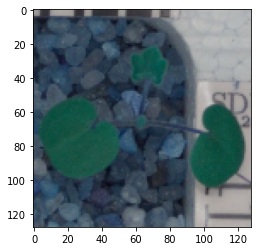

In [ ]:
#Visualize predictions for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59]
i = 2
y_pred = model.predict(x_test[i].reshape(1, 128, 128, 3))
print("Predicted label:", y_pred.argmax())
image = images[i]
plt.imshow(image);

Predicted label: 11


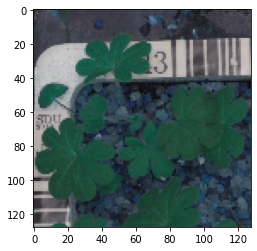

In [ ]:
#Visualize predictions  x_test[3]
i = 3
y_pred = model.predict(x_test[i].reshape(1, 128, 128, 3))
print("Predicted label:", y_pred.argmax())
image = images[i]
plt.imshow(image);

Predicted label: 0


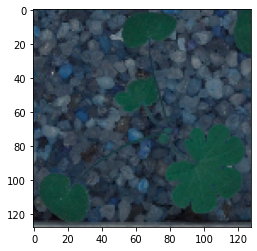

In [ ]:
#Visualize predictions for x_test[33]
i =33
y_pred = model.predict(x_test[i].reshape(1, 128, 128, 3))
print("Predicted label:", y_pred.argmax())
image = images[i]
plt.imshow(image);

Predicted label: 4


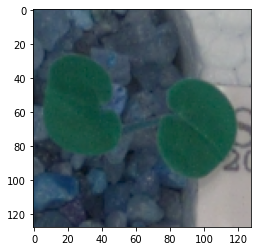

In [ ]:
#Visualize predictions for x_test[36]
i =36
y_pred = model.predict(x_test[i].reshape(1, 128, 128, 3))
print("Predicted label:", y_pred.argmax())
image = images[i]
plt.imshow(image);

Predicted label: 3


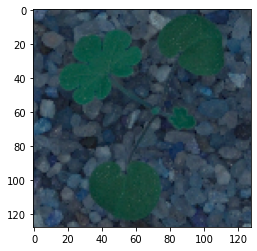

In [ ]:
#Visualize predictions for x_test[59]
i =59
y_pred = model.predict(x_test[i].reshape(1, 128, 128, 3))
print("Predicted label:", y_pred.argmax())
image = images[i]
plt.imshow(image);